In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import scipy.stats

import scipy as sp;
from numpy.random import multinomial as multi;
from numpy.random import laplace as Lap;

In [2]:
def chi2(n):
    a = 2*n[0] + n[1]; b = 2*n[3] + n[4]
    R = 2*(n[0]+n[1]+n[2]); S = 2*(n[3]+n[4]+n[5])
    N = R+S
    
    return (N*((a*S-b*R)**2))/(R*S*(a+b)*(N-a-b))

In [3]:
# SHD [Simmons and Berger, Bioinformatics 32(9) 2016](http://cb.csail.mit.edu/cb/DiffPriv/)

def getQ(r0,r1,r2,s0,s1,s2,R,S,N,c):
    Q=[];
    ##Want to find all (p0,p1) that should be in Q
    for p0 in [2*(r0+r2)+r1,2*r0+r1,r1,0,2*R]:##first consider fixed p0
        p=float(p0);
        c0=2*N/float(c*R*S);
        c0=1/c0;
        ##use quadratic equation to find possible values for p1
        A=R**2/c0+1;
        B=2.0*p-2*N-2*p*R*S/c0;
        C=p**2*S**2/c0+p**2-2*N*p;
        det=B**2-4*A*C;
        if det<0:
            continue;
        det=math.sqrt(det);
        p1p=(-B+det)/float(2*A)	
    
        p1n=(-B-det)/float(2*A)	
        if p1p<=2*S and p1p>=0 and p+p1p!=0 and p1p+p!=2*N:
            Q.append([p,p1p]);

        if p1n<=2*S and p1n>=0 and p+p1n!=0 and p1n+p!=2*N:
            Q.append([p,p1n]);

    for p1 in [2*(s0+s2)+s1,2*s0+s1,s1,0,2*S]:##then similar for fixed p1
        p=float(p1);
        c0=2*N/float(c*R*S);
        c0=1/c0;
        A=S**2/c0+1;
        B=2.0*p-2*N-2*p*R*S/c0;
        C=p**2*R**2/c0+p**2-2*N*p;
        det=B**2-4*A*C;
        if det<0:
            continue;
        det=math.sqrt(det);
        p1p=(-B+det)/float(2*A)
    
        p1n=(-B-det)/float(2*A)

        if p1p<=2*R and p1p>=0 and p1p+p!=0 and p1p+p!=2*N:
            Q.append([p1p,p]);

        if p1n<=2*R and p1n>=0 and p1n+p!=0 and p1n+p!=2*N:
            Q.append([p1n,p]);

    return Q;

def getP(R,S,N,c):
    P=[];
    for dydx in [.5,2.0,1.0,0.0]:##iterates through all possible derivatives
        c0=c*R*S/float(2*N);
        a=1-R*S/c0+(1+(R*R)/c0)*dydx;
        b=1+(S*S)/c0+(1-R*S/c0)*dydx;
        d=-N*(dydx+1);
        u=-b/a;
        v=-d/a;
        ##use quad equation to find possible points
        A=S*S-2*u*R*S+u*u*R*R+c0*(1+u)**2;
        B=-2*v*R*S+2*u*v*R**2+c0*(1+u)*(v-2*N)+c0*v*(1+u);
        C=v**2*(R*R)+c0*v*(v-2*N);
        B=B/A;
        C=C/A;
        A=1.0;
        
        det=B*B-4*A*C;
        det=math.sqrt(det);
        x1=(-B+det)/float(2*A);
        y1=u*x1+v
        if 0<=x1 and x1<=2*R and 0<=y1 and y1<=2*S:
            P.append([x1,y1]);##adds first one to P
        

        x2=(-B-det)/float(2*A)

        y2=u*x2+v
        if 0<=x2 and x2<=2*R and 0<=y2 and y2<=2*S:
            P.append([x2,y2]);##adds second one to P
    return P;

def calcGi(x,r0,r1,r2,R):
    if 2*(r0+r2)+r1>=x and x>= 2*r0+r1:
        return (x-2*r0-r1)/2.0;
    if r1<=x and x<=2*r0+r1:
        return (2*r0+r1-x)/2.0;
    if x>=2*(r0+r2)+r1:
        return r2+x-2*(r0+r2)-r1;
    return r0+r1-x;

def calcG(x,y,r0,r1,r2,s0,s1,s2,R,S):
    return calcGi(x,r0,r1,r2,R)+calcGi(y,s0,s1,s2,S);

def CheckDelta(delta,r0,r1,r2,s0,s1,s2,R,S,N,c):
    x=2*r0+r1;
    y=2*s0+s1;
    ##Sanity Check
    if 2*R<x or x<0 or y<0 or 2*S<y:
        return False;
    
    ##Sets describing affine maps that need to iterate over
    U=[[2*r0+r1,2*(r0+r2)+r1],[r1,2*r0+r1],[2*(r0+r2)+r1,2*R],[0,r1]];
    U=[U[0],U[0],U[1],U[1],U[2],U[2],U[3],U[3]]
    V=[.5,.5,-.5,-.5,1.0,1.0,-1.0,-1.0];
    D=[(-2*r0-r1)/2.0,(-2*r0-r1+1)/2.0,(2*r0+r1)/2.0,(2*r0+r1+1)/2.0,-r2-2*r0-r1,-r2-2*r0-r1,r0+r1,r0+r1];
    C=[(-2*r0-r1)%2,(-2*r0-r1+1)%2,(-2*r0-r1)%2,(-2*r0-r1+1)%2,1,0,1,0];
    Up=[[2*s0+s1,2*(s0+s2)+s1],[s1,2*s0+s1],[2*(s0+s2)+s1,2*S],[0,s1]];
    Up=[Up[0],Up[0],Up[1],Up[1],Up[2],Up[2],Up[3],Up[3]]
    Vp=[.5,.5,-.5,-.5,1.0,1.0,-1.0,-1.0];
    Dp=[(-2*s0-s1)/2.0,(-2*s0-s1+1)/2.0,(2*s0+s1)/2.0,(2*s0+s1+1)/2.0,-s2-2*s0-s1,-s2-2*s0-s1,s0+s1,s0+s1];
    Cp=[(-2*s0-s1)%2,(-2*s0-s1+1)%2,(-2*s0-s1)%2,(-2*s0-s1+1)%2,1,0,1,0];


    ## iterate over all pairs
    for i in range(0,len(U)):
        for j in range(0,len(Up)):
            ##parameterization of lines
            alpha=[1.0,-V[i]/Vp[j]];
            beta=[0,(delta-D[i]-Dp[j])/Vp[j]];
            
            t1=[(U[i][0]-beta[0])/alpha[0],(U[i][1]-beta[0])/alpha[0]];
            t2=[(Up[j][0]-beta[1])/alpha[1],(Up[j][1]-beta[1])/alpha[1]];
            if t2[0]>t2[1]:
                t2=[t2[1],t2[0]]
            if t1[0]>t1[1]:
                t1=[t1[1],t1[0]]
            a=max(t1[0],t2[0]);
            b=min(t1[1],t2[1]);
            if b<a:
                continue;
            ##use quadratic equation to find interval so parameterization gives solution in that interval
            c0=c*R*S/float(2*N);
            A=alpha[0]**2*S**2+alpha[1]**2*R**2-2*alpha[0]*alpha[1]*R*S+c0*(alpha[0]+alpha[1])**2;
            B=-2*alpha[0]*beta[1]*R*S+2*alpha[1]*beta[1]*R**2+c0*(alpha[0]+alpha[1])*(2*beta[1]-2*N);
            Ctemp=beta[1]**2*R**2+c0*beta[1]*(beta[1]-2*N);
            A=float(A);
            B=float(B);
            Ctemp=float(Ctemp);
            if A<0:
                A=-A;
                B=-B;
                Ctemp=-Ctemp;
            det=B**2-4*A*Ctemp;
            if det<0:
                continue;
            det=math.sqrt(det);
            p0=(-B-det)/float(2*A)
            x0=alpha[0]*p0+beta[0];
            y0=alpha[1]*p0+beta[1];
            p1=(-B+det)/float(2*A)
            a=max(a,p0);
            b=min(b,p1);
            if b<a:	
                continue;
            if math.ceil(a)>b:
                continue;

            ##Check if any integer solution in interval meeting modularity constraints-- if so return it, else continue
            ca=int(math.ceil(a));
            if not (alpha[1]*ca+beta[1]).is_integer():
                ca=ca+1;
            if ca>b:
                continue;
            if int(alpha[0]*ca+beta[0])%2==C[i] and int(alpha[1]*ca+beta[1])%2==Cp[j]:
                return [alpha[0]*ca,alpha[1]*ca+beta[1]];
            ca=ca+1;
            if not (alpha[1]*ca+beta[1]).is_integer():
                ca=ca+1;
            if ca>b:
                continue;
            if int(alpha[0]*ca+beta[0])%2==C[i] and int(alpha[1]*ca+beta[1])%2==Cp[j]:
                return [alpha[0]*ca,alpha[1]*ca+beta[1]];

    return [];##if no such points exist

def neighDistSig(r0,r1,r2,s0,s1,s2,c,R,S,N,P=[],rnd=False):
    x=2*r0+r1;
    y=2*s0+s1;
    ##Some sanity checks
    if c<=0:
        return -1;
    if r0<0 or r1<0 or r2<0 or s0<0 or s2<0 or s1<0:
        return -1;
    if len(P)==0:##if did not already generate P
        P=getP(R,S,N,c);

    Q=getQ(r0,r1,r2,s0,s1,s2,R,S,N,c);##Calculates set Q

    delta1=min([calcG(p[0],p[1],r0,r1,r2,s0,s1,s2,R,S) for p in P])##min distance in P

    delta2=min([calcG(p[0],p[1],r0,r1,r2,s0,s1,s2,R,S) for p in Q])##min distance in Q
    delta=min(delta1,delta2);
    delta=math.ceil(delta);##optimum of relaxed problem
    if rnd:##called if not a significant SNP
        return delta;

    ##now round to integer solution
    for d in [delta-2,delta-1,delta,delta+1,delta+2,delta+3]:
        keyDel=CheckDelta(d,r0,r1,r2,s0,s1,s2,R,S,N,c)##Checks if exists database within distance d with score less than c
        if len(keyDel)>0:##if such a database exists
            return d;

    return -1;##Means failed

def SHD(r0,r1,r2,s0,s1,s2,c,R,S,N,P,simp=False):
    x=2*r0+r1;
    y=2*s0+s1;
    if c<=2*N*(x*S-y*R)**2/float(R*S*(x+y)*(2*N-x-y)):
        dst=neighDistSig(r0,r1,r2,s0,s1,s2,c,R,S,N,P);##if greater than boundary
        return dst;
    dst=neighDistSig(r0,r1,r2,s0,s1,s2,c,R,S,N,rnd=True);##if less than boundary
    if simp:
        return dst;
    return 1-dst;

In [4]:
# pseudo_SHD

def pseudo_SHD(n):
    a = 2*n[0] + n[1]; b = 2*n[3] + n[4]
    c = n[1] + 2*n[2]; d = n[4] + 2*n[5]
    
    return (math.fabs(a-b)+math.fabs(c-d))/4

In [5]:
# exponential mechanism

def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(score, m, K, epsilon):
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    s = np.zeros(m)
    for i in range(m):
        s[i] = score[i]
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * s[i] / (2*K))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
            
        x = random_num(p)
        s[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

In [6]:
# (Efficient) Joint Permute-and-Flip

def JointPnF(score, m, K, epsilon):
    S = np.zeros(K)
    SS = np.zeros(K)
    w = np.zeros(m)
    
    si = np.argsort(-score)
    c = np.zeros(m)
    for i in range(m):
        c[si[i]] = i
    ss = sorted(score, reverse=True)
    for i in range(K-1,m):
        if i == K-1:
            C = 1
        else:
            C = (C/(i-K+1)) * i
        r = np.random.rand()
        if r**(1/C)==1:
            D = C
            p = 16
            while(1):
                D /= 10
                p += 1
                if r**(1/D) != 1:
                    l = (1 - r**(1/D))*(10**16)
                    break
            x = -(2/epsilon)*(math.log(l) + (-1*p)*math.log(10))
        else:
            x = -(2/epsilon)*math.log(1-r**(1/C))
        w[i] = ss[i] + x
    SS[K-1] = np.argmax(w[K-1:m]) + K-1
    SS[0:K-1] = np.random.choice(int(SS[K-1]), size=K-1, replace=False)
    
    for i in range(K):
        S[i] = c[int(SS[i])]
    
    return S

In [7]:
def generate_data(N, M):
    S = np.zeros(M)
    b = np.zeros(M)
    c = np.zeros(M)
    n = np.zeros((M,6))
    
    for i in range(M-10):
        n[i][0] = np.random.binomial(int(N/2),1/3)
        n[i][1] = np.random.binomial((int(N/2)-n[i][0]), 1/2)
        n[i][2] = int(N/2)-n[i][0]-n[i][1]
        n[i][3] = np.random.binomial(int(N/2),1/3)
        n[i][4] = np.random.binomial((int(N/2)-n[i][3]), 1/2)
        n[i][5] = int(N/2)-n[i][3]-n[i][4]
    
    for i in range(M-10,M):
        n[i][0] = np.random.binomial(int(N/2),1/7)
        n[i][1] = np.random.binomial((int(N/2)-n[i][0]), 1/4)
        n[i][2] = int(N/2)-n[i][0]-n[i][1]
        n[i][3] = np.random.binomial(int(N/2),1/2)
        n[i][4] = np.random.binomial((int(N/2)-n[i][3]), 1/1.5)
        n[i][5] = int(N/2)-n[i][3]-n[i][4]
    
    return n

In [8]:
def evaluation(K, N, M):
    accuracy = np.zeros((7,3))
    b = np.zeros(M)
    c = np.zeros(M)
    stats = np.zeros(M)
    
    correct = np.zeros((7,3))
    
    for j in range(50):
        n = generate_data(N,M)
        
        for i in range(M):
            stats[i] = chi2(n[i])
            
        EXACT = np.zeros(M)
        PSEUDO = np.zeros(M)
        
        x = np.argsort(-stats)
        
        cc = 19.5
        
        for i in range(M):
            a = int(x[i])
            r0 = int(n[a][0]); r1 = int(n[a][1]); r2 = int(n[a][2])
            s0 = int(n[a][3]); s1 = int(n[a][4]); s2 = int(n[a][5])
            R = 2*(r0+r1+r2); S = 2*(s0+s1+s2)
            k = [r0,r1,r2,s0,s1,s2]
            PSEUDO[i] = pseudo_SHD(k)
            EXACT[i] = SHD(r0,r1,r2,s0,s1,s2,cc,R,S,N,P=[])
        
        #print(simple_shd)
    
        for i in range(7):
            pseudo_shd = PSEUDO
            shd = EXACT
            if K == 7:
                shdExp_result = exp_mec(shd,M,K,i+3.7)
                pseudoExp_result = exp_mec(pseudo_shd,M,K,i+3.7)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+3.7)
            if K == 5:
                shdExp_result = exp_mec(shd,M,K,i+2.5)
                pseudoExp_result = exp_mec(pseudo_shd,M,K,i+2.5)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+2.5)
            if K == 3:
                shdExp_result = exp_mec(shd,M,K,i+1.5)
                pseudoExp_result = exp_mec(pseudo_shd,M,K,i+1.5)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+1.5)
            if K == 1:
                shdExp_result = exp_mec(shd,M,K,i+1.0)
                pseudoExp_result = exp_mec(pseudo_shd,M,K,i+1.0)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+1.0)
            for k in range(K):
                if shdExp_result[k] < K:
                    correct[i][0] += 1
                if pseudoExp_result[k] < K:
                    correct[i][1] += 1
                if JointPnF_result[k] < K:
                    correct[i][2] += 1
                
    accuracy = correct/(50*K)
    return accuracy

[[0.54571429 0.57142857 0.54857143]
 [0.73428571 0.79428571 0.91142857]
 [0.84571429 0.81714286 0.94      ]
 [0.88285714 0.88571429 0.94857143]
 [0.89428571 0.91714286 0.96      ]
 [0.92       0.92571429 0.95428571]
 [0.92285714 0.93142857 0.96285714]]
[[0.60857143 0.57714286 0.58857143]
 [0.76285714 0.78857143 0.92285714]
 [0.84       0.84       0.93714286]
 [0.90285714 0.89714286 0.95428571]
 [0.90285714 0.91142857 0.95714286]
 [0.95428571 0.93428571 0.97428571]
 [0.91714286 0.92571429 0.97714286]]
[[0.52571429 0.58285714 0.72      ]
 [0.76285714 0.78571429 0.92571429]
 [0.85714286 0.87714286 0.92857143]
 [0.89428571 0.89428571 0.94571429]
 [0.89714286 0.88285714 0.96      ]
 [0.91714286 0.92       0.94857143]
 [0.91428571 0.93428571 0.96      ]]
[[0.52857143 0.59428571 0.53142857]
 [0.74857143 0.78285714 0.92      ]
 [0.82857143 0.85428571 0.92      ]
 [0.86571429 0.91142857 0.93714286]
 [0.87714286 0.90285714 0.95142857]
 [0.89142857 0.87142857 0.95428571]
 [0.90285714 0.91714286 0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.55428571 0.53142857 0.61714286]
 [0.72285714 0.75714286 0.88857143]
 [0.82571429 0.81714286 0.90857143]
 [0.87714286 0.90857143 0.92285714]
 [0.88857143 0.86857143 0.94      ]
 [0.91428571 0.9        0.94285714]
 [0.91428571 0.92285714 0.96285714]]
[[0.55257143 0.57142857 0.60114286]
 [0.74628571 0.78171429 0.91371429]
 [0.83942857 0.84114286 0.92685714]
 [0.88457143 0.89942857 0.94171429]
 [0.892      0.89657143 0.95371429]
 [0.91942857 0.91028571 0.95485714]
 [0.91428571 0.92628571 0.96285714]]


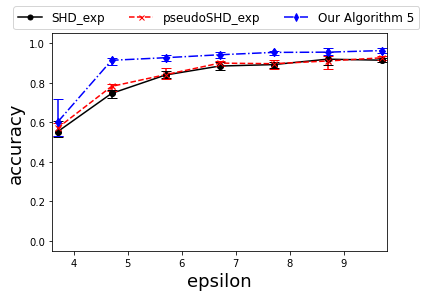

In [9]:
# n = 150, M = 5000
# K = 7

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3)); min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,3))

for j in range(5):
    accuracy = evaluation(7,150,5000)
    for i in range(7):
        epsilon[i] = i+3.7
        for k in range(3):
            if accuracy[i][k] > max_acc[i][k]:
                max_acc[i][k] = accuracy[i][k]
            if accuracy[i][k] < min_acc[i][k]:
                min_acc[i][k] = accuracy[i][k]
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)
accuracy = sum_acc/5

for k in range(3):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)
fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(3.6, 9.8)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "black", linestyle = "-", label = "SHD_exp")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='x', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,1], marker="x", markersize=5, color = "red", linestyle = "--", label = "pseudoSHD_exp")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,2], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Our Algorithm 5")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("Accuracy_chi2_K=7.png")
fig.savefig("figs/Accuracy_chi2_K=7.eps")

[[0.472 0.468 0.46 ]
 [0.7   0.696 0.844]
 [0.828 0.796 0.872]
 [0.796 0.816 0.908]
 [0.836 0.844 0.916]
 [0.876 0.852 0.924]
 [0.896 0.872 0.928]]
[[0.444 0.476 0.444]
 [0.712 0.7   0.8  ]
 [0.8   0.816 0.86 ]
 [0.864 0.852 0.88 ]
 [0.824 0.844 0.908]
 [0.912 0.9   0.928]
 [0.876 0.876 0.928]]
[[0.456 0.468 0.54 ]
 [0.716 0.716 0.812]
 [0.804 0.792 0.86 ]
 [0.836 0.824 0.868]
 [0.844 0.86  0.912]
 [0.884 0.856 0.952]
 [0.872 0.88  0.948]]
[[0.464 0.444 0.592]
 [0.712 0.74  0.896]
 [0.796 0.812 0.888]
 [0.836 0.856 0.908]
 [0.88  0.876 0.928]
 [0.876 0.892 0.928]
 [0.88  0.916 0.956]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.456 0.48  0.468]
 [0.704 0.756 0.864]
 [0.816 0.788 0.88 ]
 [0.84  0.844 0.924]
 [0.864 0.884 0.916]
 [0.888 0.884 0.932]
 [0.892 0.92  0.96 ]]
[[0.4584 0.4672 0.5008]
 [0.7088 0.7216 0.8432]
 [0.8088 0.8008 0.872 ]
 [0.8344 0.8384 0.8976]
 [0.8496 0.8616 0.916 ]
 [0.8872 0.8768 0.9328]
 [0.8832 0.8928 0.944 ]]


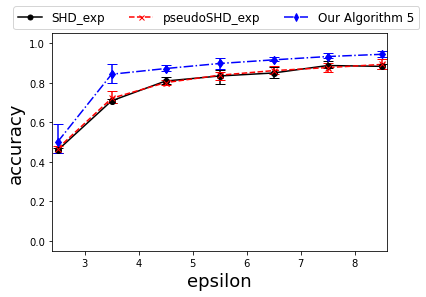

In [10]:
# n = 150, M = 5000
# K = 5

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3)); min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,3))

for j in range(5):
    accuracy = evaluation(5,150,5000)
    for i in range(7):
        epsilon[i] = i+2.5
        for k in range(3):
            if accuracy[i][k] > max_acc[i][k]:
                max_acc[i][k] = accuracy[i][k]
            if accuracy[i][k] < min_acc[i][k]:
                min_acc[i][k] = accuracy[i][k]
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)
accuracy = sum_acc/5

for k in range(3):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)
fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(2.4, 8.6)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "black", linestyle = "-", label = "SHD_exp")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='x', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,1], marker="x", markersize=5, color = "red", linestyle = "--", label = "pseudoSHD_exp")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,2], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Our Algorithm 5")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("Accuracy_chi2_K=5.png")
fig.savefig("figs/Accuracy_chi2_K=5.eps")

[[0.37333333 0.45333333 0.47333333]
 [0.69333333 0.69333333 0.76      ]
 [0.76666667 0.72666667 0.79333333]
 [0.8        0.80666667 0.89333333]
 [0.83333333 0.81333333 0.87333333]
 [0.86       0.84666667 0.9       ]
 [0.92666667 0.88       0.92666667]]
[[0.34       0.37333333 0.46666667]
 [0.69333333 0.70666667 0.76666667]
 [0.77333333 0.69333333 0.84666667]
 [0.78       0.81333333 0.88666667]
 [0.78666667 0.86       0.87333333]
 [0.82666667 0.86       0.86      ]
 [0.84666667 0.84       0.9       ]]
[[0.47333333 0.38666667 0.58666667]
 [0.73333333 0.69333333 0.81333333]
 [0.84       0.74       0.86666667]
 [0.83333333 0.86666667 0.85333333]
 [0.87333333 0.82666667 0.89333333]
 [0.87333333 0.88       0.89333333]
 [0.90666667 0.88       0.93333333]]
[[0.40666667 0.42666667 0.39333333]
 [0.70666667 0.73333333 0.77333333]
 [0.76       0.81333333 0.84666667]
 [0.8        0.86       0.88666667]
 [0.84666667 0.82       0.91333333]
 [0.86666667 0.84       0.94      ]
 [0.85333333 0.91333333 0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.37333333 0.43333333 0.46666667]
 [0.70666667 0.72       0.76666667]
 [0.78666667 0.81333333 0.87333333]
 [0.81333333 0.84       0.89333333]
 [0.84       0.87333333 0.94666667]
 [0.86       0.89333333 0.94666667]
 [0.90666667 0.88666667 0.95333333]]
[[0.39333333 0.41466667 0.47733333]
 [0.70666667 0.70933333 0.776     ]
 [0.78533333 0.75733333 0.84533333]
 [0.80533333 0.83733333 0.88266667]
 [0.836      0.83866667 0.9       ]
 [0.85733333 0.864      0.908     ]
 [0.888      0.88       0.932     ]]


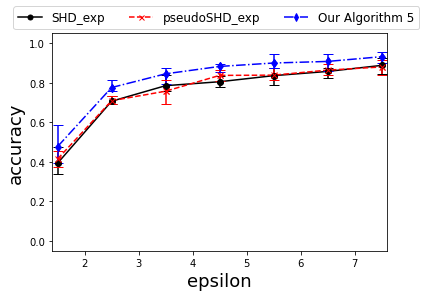

In [11]:
# n = 150, M = 5000
# K = 3

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3)); min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,3))

for j in range(5):
    accuracy = evaluation(3,150,5000)
    for i in range(7):
        epsilon[i] = i+1.5
        for k in range(3):
            if accuracy[i][k] > max_acc[i][k]:
                max_acc[i][k] = accuracy[i][k]
            if accuracy[i][k] < min_acc[i][k]:
                min_acc[i][k] = accuracy[i][k]
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)
accuracy = sum_acc/5

for k in range(3):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)
fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(1.4, 7.6)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "black", linestyle = "-", label = "SHD_exp")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='x', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,1], marker="x", markersize=5, color = "red", linestyle = "--", label = "pseudoSHD_exp")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,2], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Our Algorithm 5")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("Accuracy_chi2_K=3.png")
fig.savefig("figs/Accuracy_chi2_K=3.eps")

[[0.5  0.66 0.64]
 [0.8  0.78 0.88]
 [0.86 0.84 0.86]
 [0.84 0.96 0.92]
 [0.92 0.92 0.92]
 [0.9  0.96 0.94]
 [0.9  0.94 0.94]]
[[0.48 0.62 0.7 ]
 [0.72 0.8  0.88]
 [0.88 0.78 0.86]
 [0.86 0.9  0.92]
 [0.88 0.9  0.9 ]
 [0.94 0.96 0.9 ]
 [0.92 0.94 0.92]]
[[0.56 0.66 0.66]
 [0.72 0.74 0.78]
 [0.84 0.84 0.82]
 [0.78 0.9  0.94]
 [0.86 0.9  0.76]
 [0.88 0.84 0.9 ]
 [0.86 0.86 0.92]]
[[0.48 0.44 0.64]
 [0.78 0.78 0.84]
 [0.86 0.88 0.9 ]
 [0.9  0.94 0.96]
 [0.82 0.92 0.94]
 [0.86 0.92 0.96]
 [0.94 1.   0.92]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.4  0.54 0.64]
 [0.66 0.64 0.74]
 [0.8  0.88 0.84]
 [0.86 0.86 0.94]
 [0.9  0.94 0.94]
 [0.92 0.9  0.98]
 [0.92 0.94 0.98]]
[[0.484 0.584 0.656]
 [0.736 0.748 0.824]
 [0.848 0.844 0.856]
 [0.848 0.912 0.936]
 [0.876 0.916 0.892]
 [0.9   0.916 0.936]
 [0.908 0.936 0.936]]


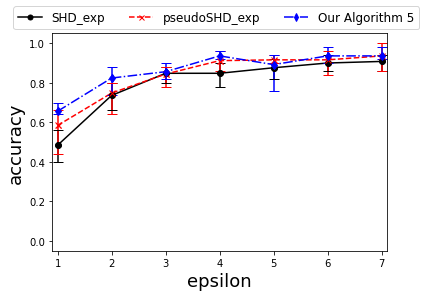

In [12]:
# n = 150, M = 5000
# K = 1

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3)); min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,3))

for j in range(5):
    accuracy = evaluation(1,150,5000)
    for i in range(7):
        epsilon[i] = i+1.0
        for k in range(3):
            if accuracy[i][k] > max_acc[i][k]:
                max_acc[i][k] = accuracy[i][k]
            if accuracy[i][k] < min_acc[i][k]:
                min_acc[i][k] = accuracy[i][k]
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)
accuracy = sum_acc/5

for k in range(3):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)
fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(0.9, 7.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "black", linestyle = "-", label = "SHD_exp")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='x', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,1], marker="x", markersize=5, color = "red", linestyle = "--", label = "pseudoSHD_exp")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,2], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Our Algorithm 5")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("Accuracy_chi2_K=1.png")
fig.savefig("figs/Accuracy_chi2_K=1.eps")